# LSST Visibility and Visits

In [35]:
from os import path
import rubin_sim.maf as maf
from rubin_sim.data import get_data_dir, get_baseline, data_dict
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.coordinates import SkyCoord, Galactic
from astropy import units as u
from astropy.io import fits
import json

Firstly, we extract the number of visits made by Rubin over 10yrs (including all filters) from the baseline_v4.3.1 OpSim database, by calculating the Nvis metric.

In [2]:
#opsim_db_file = '/Users/rstreet/rubin_sim_data/sim_baseline/baseline_v4.3.1_10yrs.db'
opsdb = get_baseline()
runName = path.basename(opsdb).replace('.db','')
print(runName)

baseline_v4.3.1_10yrs


[Documentation on available columns](https://rubin-scheduler.lsst.io/fbs-output-schema.html)

In [28]:
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)
outDir = '/Users/rstreet/LSST/SCOC/Survey_Footprint'

bundleList = []
metric1 = maf.metrics.CountMetric(col='observationStartMJD', metric_name='Nvisits')
constraint = 'fiveSigmaDepth > 21.5'
slicer = maf.slicers.HealpixSlicer(nside=NSIDE, use_cache=False)
plotDict = {'colorMax': 950}

bundle = maf.MetricBundle(metric1, slicer, constraint, run_name=runName, plot_dict=plotDict)
bgroup = maf.MetricBundleGroup({'nvisits': bundle}, opsdb, out_dir=outDir, results_db=None)

bgroup.run_all()


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/var/folders/1d/5hlyfsgd0kl_nd815xmp9cv00000gn/T/ipykernel_86163/1685734160.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


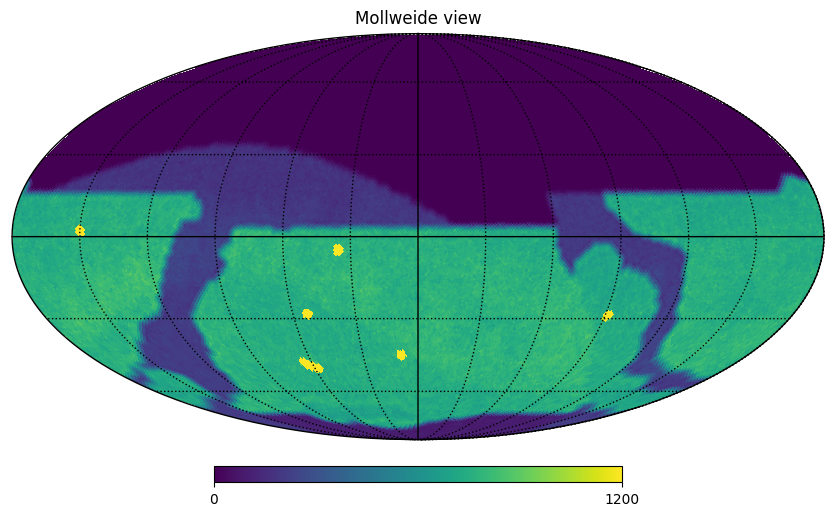

In [30]:
metricData = bgroup.bundle_dict['nvisits'].metric_values.filled(0.0)
fig = plt.figure(1,(10,10))
hp.mollview(metricData, min=0, max=1200)
hp.graticule()
plt.tight_layout()
plt.close(1)

## Sky Region in the Galactic Plane

Baseline_v2.0 included a region in the central Galactic Plane dubbed "the Diamond".  Here we calculate a rough estimate of the total number of square degrees included in this region. 

Firstly, we calculate the sky coordinates for the centre of each HEALpixel

In [31]:
metricData = bgroup.bundle_dict['nvisits'].metric_values.filled(0.0)

pixelPositions = []
(theta, phi) = hp.pix2ang(NSIDE,range(0,len(metricData),1))

ra = np.rad2deg(phi)
dec = np.rad2deg((np.pi/2.0) - theta)

skyPositions = SkyCoord(ra*u.deg,
                        dec*u.deg,
                        frame='icrs')
galPositions = skyPositions.transform_to(Galactic)

We can now use these positions to identify those HEALpixels within the Galactic Plane.  It used to be possible to identify observations from the Galactic Plane survey from the OpSim DB but it is not clear if this is still the case.  Hence the complicated masking to isolate the irregular survey footprint.

/var/folders/1d/5hlyfsgd0kl_nd815xmp9cv00000gn/T/ipykernel_86163/3209327179.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


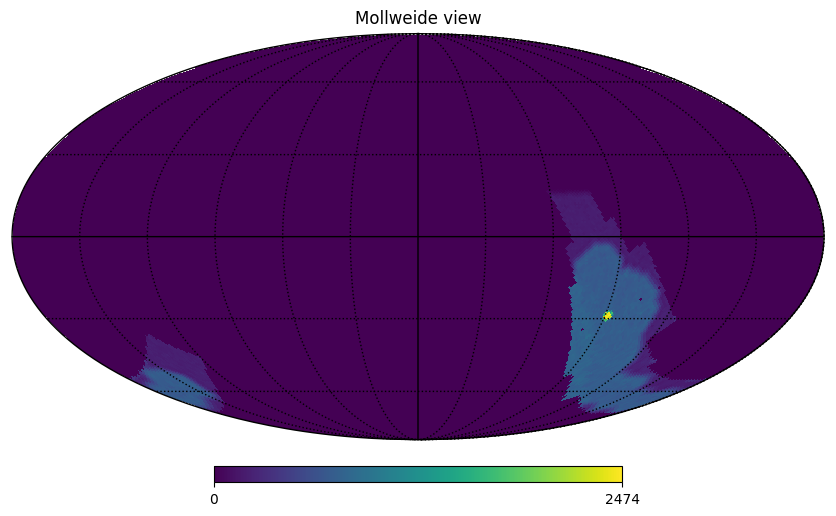

In [32]:
# Mask for the extended Galactic Plane
m1 = abs(galPositions.b.deg) < 8.0
m2 = galPositions.l.deg > 260.0
m2_2 = galPositions.l.deg > 359.9
mp1 = np.logical_and(m1, m2)
mp2 = np.logical_and(m1, m2_2)
mask_gp1 = np.logical_or(mp1, mp2)

m2 = galPositions.l.deg < 90.0
mask_gp2 = np.logical_and(m1, m2)
mask_gp = np.logical_or(mask_gp1, mask_gp2)

# Mask for the central Galactic Bulge 
m1 = galPositions.b.deg > -15.0
m2 = galPositions.b.deg < 20.0
m3 = galPositions.l.deg > 0.0
m4 = galPositions.l.deg < 20.0
m5 = galPositions.l.deg > 340.0
m6 = galPositions.l.deg < 359.9
mask_b = np.logical_and(m1, m2)
mask_l1 = np.logical_and(m3, m4)
mask_l2 = np.logical_and(m5, m6)
mask_l = np.logical_or(mask_l1, mask_l2)
mask_gb = np.logical_and(mask_l, mask_b)

# Mask for the wings of the Galactic Bulge
m1 = galPositions.b.deg > -12.0
m2 = galPositions.b.deg < 12.0
m3 = galPositions.l.deg > 0.0
m4 = galPositions.l.deg < 35.0
mask_b = np.logical_and(m1, m2)
mask_l = np.logical_and(m3, m4)
mask_gb2 = np.logical_and(mask_l, mask_b)

m1 = galPositions.b.deg > -12.0
m2 = galPositions.b.deg < 10.0
m3 = galPositions.l.deg > 325.0
m4 = galPositions.l.deg < 359.9
mask_b = np.logical_and(m1, m2)
mask_l = np.logical_and(m3, m4)
mask_gb3 = np.logical_and(mask_l, mask_b)

mask_gb = np.logical_or(mask_gb, mask_gb2)
mask_gb = np.logical_or(mask_gb, mask_gb3)

# Combine the masks 
mask = np.logical_or(mask_gp, mask_gb) 
#mask = mask_gb2

galPlaneData = np.zeros(NPIX)
galPlaneData[mask] = metricData[mask]

fig = plt.figure(3,(10,10))
hp.mollview(galPlaneData)
hp.graticule()
plt.tight_layout()
#plt.savefig(file_name)
plt.close(3)

However, this includes large regions where the number of visits is still very low, so we exclude these with a cut on the number of visits per pointing over 10yrs.

/var/folders/1d/5hlyfsgd0kl_nd815xmp9cv00000gn/T/ipykernel_86163/637381144.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


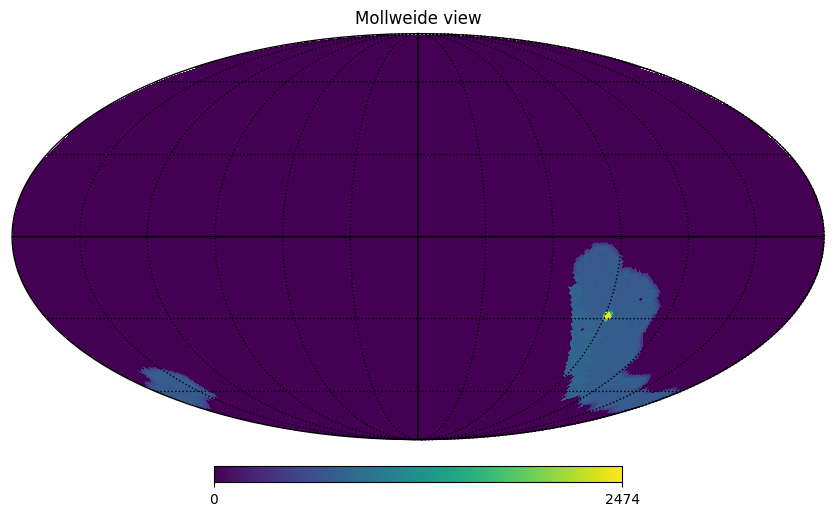

In [33]:
mask2 = galPlaneData > 400
galPlaneRegion = np.zeros(NPIX)
galPlaneRegion[mask2] = metricData[mask2]

fig = plt.figure(4,(10,10))
hp.mollview(galPlaneRegion)
hp.graticule()
plt.tight_layout()
#plt.savefig(file_name)
plt.close(4)

Now we can use the selected HEALpixels to estimate the total area in the Galactic Plane visited more than a "background" number of times. 

In [34]:
pix_area = hp.nside2pixarea(NSIDE,degrees=True)
pix_index = np.where(mask2)[0]
region_area = len(pix_index) * pix_area
print('Total area surveyed in the Galactic Plane: '+str(round(region_area,2))+' sq deg')

Total area surveyed in the Galactic Plane: 2162.02 sq deg


In [36]:
# Output the pixel map data 
output = {
        "label": 'Rubin_'+runName,
        "nside": NSIDE,
        "healpix_resolution_deg": hp.nside2pixarea(NSIDE),
        "n_healpix": hp.nside2npix(NSIDE),
    }
output['healpix_map'] = galPlaneRegion.tolist()

# Serializing json
json_object = json.dumps(output, indent=4)

# Writing to sample.json
with open(path.join('/Users/rstreet/LSST/SCOC/Survey_Footprint', 'rubin_galplane_footprint.json'), "w") as f:
    f.write(json_object)

## Depreciated 

The following code worked with a previous version of rubin_sim and is kept for reference. 

In [ ]:
from rubin_sim.scheduler.utils import Sky_area_generator

nside = 64

# Sky_area_generator - from rubin_sim/scheduler/utils
sky = Sky_area_generator(nside=nside)
maps, labels = sky.return_maps()

wfd_indx = np.where(labels == 'lowdust')[0]
bulge_idx = np.where(labels == 'bulge')[0]
mcs_idx = np.where(labels == 'LMC_SMC')[0]

area = (len(bulge_idx)+len(mcs_idx)) * hp.nside2pixarea(nside, degrees=True)
print(area)
not_wfd_idx = np.where(labels != 'lowdust')[0]

In [ ]:
region = np.zeros(NPIX)
region[not_wfd_idx] = metricData[not_wfd_idx]

fig = plt.figure(4,(10,10))
hp.mollview(region)
hp.graticule()
plt.tight_layout()
#plt.savefig(file_name)
plt.close(4)

In [ ]:
labels

In [ ]:
np.unique(labels)

In [ ]:
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)
outDir = '/Users/rstreet/LSST/SCOC/Survey_Footprint'

bundleList = []
metric2 = maf.metrics.PassMetric(cols=['filter', 'observationStartMJD', 'fiveSigmaDepth', 'observation_reason', 'science_program'])

constraint = None

slicer = maf.slicers.HealpixSlicer(nside=NSIDE, use_cache=False)

bundle = maf.MetricBundle(metric2, slicer, constraint, run_name=runName)
bgroup2 = maf.MetricBundleGroup({'nvisits': bundle}, opsdb, out_dir=outDir, results_db=None)

bgroup2.run_all()

## Rubin Visibility Zone

We can infer those regions of the sky within the Rubin visibility limits from the number of visits per pointing returned from this metric.

In [ ]:
mask = bgroup.bundle_dict['nvisits'].metric_values.mask

rubin_visibility_zone = np.where(mask == False)[0]

rubin_visibility_map = np.zeros(NPIX)
rubin_visibility_map[rubin_visibility_zone] = 1.0

In [ ]:
fig = plt.figure(2,(10,10))
hp.mollview(rubin_visibility_map)
hp.graticule()
plt.tight_layout()
#plt.savefig(file_name)
plt.close(2)